In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow 
plt.tight_layout()
import time

from IPython import display
import seaborn as sns
sns.set_style("darkgrid")



In [2]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        
        return G.div(a * b * c * d)


In [3]:
import torch.optim as optim
import torchvision.models as models

class StyleCNN(object):
    def __init__(self, style, content, pastiche):
        super(StyleCNN, self).__init__()
        
        self.style = style
        self.content = content
        self.pastiche = nn.Parameter(pastiche.data)
        
        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        self.content_weight = 1
        self.style_weight = 2000
        
        self.loss_network = models.vgg19(pretrained=True)
        
        self.gram = GramMatrix()
        self.loss = nn.MSELoss()
        self.optimizer = optim.LBFGS([self.pastiche])
        
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.loss_network.cuda()
            self.gram.cuda()

    def train(self):
        def closure():
            self.optimizer.zero_grad()
          
            pastiche = self.pastiche.clone()
            pastiche.data.clamp_(0, 1)
            content = self.content.clone()
            style = self.style.clone()
            
            content_loss = 0
            style_loss = 0
            
            i = 1
            not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
            for layer in list(self.loss_network.features):
                layer = not_inplace(layer)
                if self.use_cuda:
                    layer.cuda()
                    
                pastiche, content, style = layer.forward(pastiche), layer.forward(content), layer.forward(style)
                
                if isinstance(layer, nn.Conv2d):
                    name = "conv_" + str(i)
                    
                    if name in self.content_layers:
                        content_loss += self.loss(pastiche * self.content_weight, content.detach() * self.content_weight)
                    
                    if name in self.style_layers:
                        pastiche_g, style_g = self.gram.forward(pastiche), self.gram.forward(style)
                        style_loss += self.loss(pastiche_g * self.style_weight, style_g.detach() * self.style_weight)
                
                if isinstance(layer, nn.ReLU):
                    i += 1
            
            total_loss = content_loss + style_loss
            total_loss.backward()
            
            return total_loss
    
        self.optimizer.step(closure)
        return self.pastiche


In [4]:
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image
import scipy.misc

imsize = 256

loader = transforms.Compose([
             transforms.Resize(imsize),
             transforms.ToTensor()
         ])

unloader = transforms.ToPILImage()

def image_loader(image_name):
    image = Image.open(image_name).resize((imsize, imsize))
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

def convert_image(input):
    image = input.data.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    print(image)
    return image

def save_image(input, path):
    image = input.data.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    scipy.misc.imsave(path, image)


In [5]:
import torch.utils.data
import torchvision.datasets as datasets
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


In [7]:
style = image_loader("styles/scream.jpg").type(dtype)
content = image_loader("content/mohanty.jpg").type(dtype)

pastiche = image_loader("content/mohanty.jpg").type(dtype)


Iteration : 199


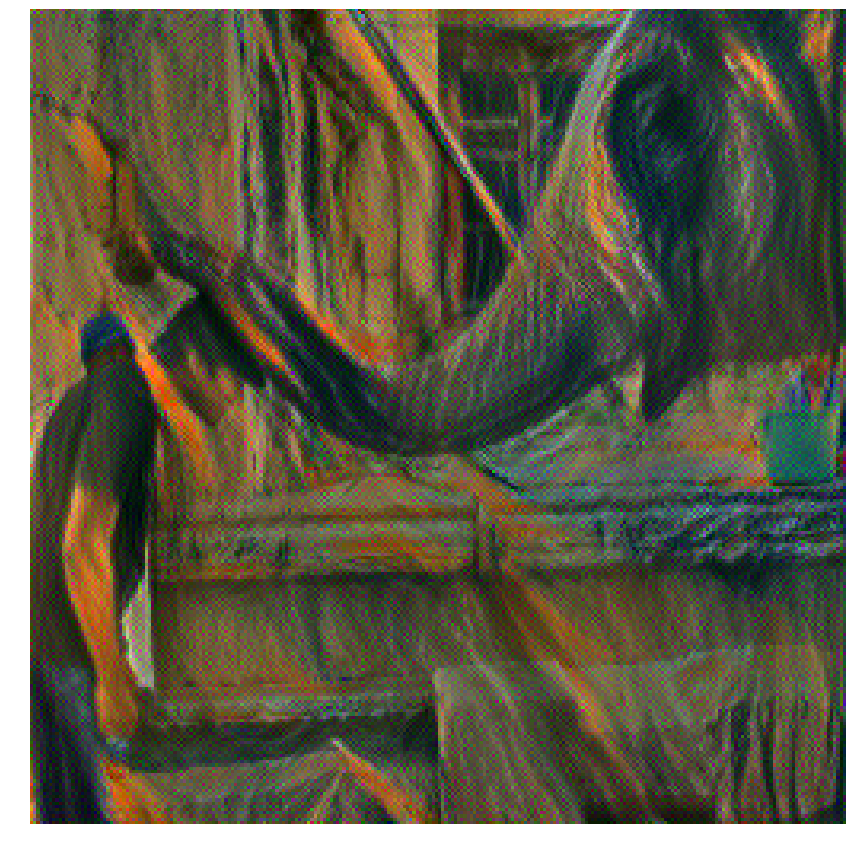

In [8]:
# fig = plt.figure(figsize= (15,15)) 
# plt.axis('off')
# im = convert_image(pastiche)
# imshow(im)

from IPython import display


num_epochs = 200

style_cnn = StyleCNN(style, content, pastiche)

for i in range(num_epochs):
    print("Iteration : {}".format(i))    
    pastiche = style_cnn.train()
    pastiche.data.clamp_(0, 1)
    im = convert_image(pastiche)
    fig = plt.figure(figsize= (15,15)) 
    plt.axis('off')    
    imshow(im)    
    display.clear_output(wait=True)        
    print("Iteration : {}".format(i))    
    plt.show()    
